# Build a footprint of the NEON archive (local)

#### Summary
After aquiring the NEON archive and storing locally, this notebook will:
1. build a geodataframe  
2. save a geopackage  
3. map a geodataframe  

of the NEON subtiles across all year and all sites of the NEON archive.  



Paul Montesano | NASA GSFC

In [2]:
# import rasterio
# import rasterio.features
# import rasterio.warp
# from rasterio.plot import show
# from rasterio import Affine, MemoryFile
# from rasterio.enums import Resampling

import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import box
import fiona
from fiona.crs import from_epsg
import pprint

import contextily as ctx

import glob
import os

import sys
sys.path.append('/efs/pmontesa/code/geoscitools')
sys.path.append('/home/pmontesa/code/geoscitools')
import maplib
import footprintlib
from footprintlib import *

### Build NEON footprint

In [3]:
footprint_dict_list = [
        # NEON Lidar: This gets ALL DSM.tif files across NEON archive
        {'location': 'local',
         'data_dir': "/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products", #/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar
         'data_source': 'NEON_DSM',
         'image_type': '**',
         'layer_name': 'all',
         'search_tail_string': '/**/*DSM.tif',#'/*DSM.tif',
         'search_link_string': '',
         'GET_BATCH': True,
         'DO_DATAMASK': False,
         'GET_ONLY_DATASETMASK': True,
         'MANY_CRS': True,
         'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/footprints',
         'footprint_name_SPLIT_CHAR': '_',
         'footprint_name_SPLIT_POS': 0,
         'aws_credential_fn': None
        },
        # NEON Derived Forest Structure Data (FSD): This gets ALL CHM.tif files across NEON archive that Glenn has processed so far
        {'location': 'local',
         'data_dir': "/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/FSD", #/2017/FullSite/D07/2017_MLBS_2/L3/DiscreteLidar
         'data_source': 'NEON_CHM',
         'image_type': '**',
         'layer_name': 'all',
         'search_tail_string': '/**/*CHM.tif',#'/*DSM.tif',
         'search_link_string': '',
         'GET_BATCH': True,
         'DO_DATAMASK': False,
         'GET_ONLY_DATASETMASK': True,
         'MANY_CRS': True,
         'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/footprints',
         'footprint_name_SPLIT_CHAR': '_',
         'footprint_name_SPLIT_POS': 0,
         'aws_credential_fn': None
        }
]

In [4]:
######################
# Select a dictionary
d = footprint_dict_list[0]
######################
d

{'location': 'local',
 'data_dir': '/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products',
 'data_source': 'NEON_DSM',
 'image_type': '**',
 'layer_name': 'all',
 'search_tail_string': '/**/*DSM.tif',
 'search_link_string': '',
 'GET_BATCH': True,
 'DO_DATAMASK': False,
 'GET_ONLY_DATASETMASK': True,
 'MANY_CRS': True,
 'out_footprint_dir': '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/footprints',
 'footprint_name_SPLIT_CHAR': '_',
 'footprint_name_SPLIT_POS': 0,
 'aws_credential_fn': None}

In [6]:
SEARCH_STR_LIST = ["/", d['image_type'], d['search_tail_string']]
keystring = d['search_link_string'].join(SEARCH_STR_LIST)
print(d['data_dir'] + keystring)

# Raster list
r_fn_list = glob.glob(d['data_dir'] + keystring, recursive=True)

/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/**/**/*DSM.tif


In [7]:
len(r_fn_list)

218584

In [8]:
from multiprocessing import Pool
from functools import partial

In [11]:
import multiprocessing as mp
mp.cpu_count()

40

### Build list of geodataframes

In [12]:
%%time
    
with Pool(processes=mp.cpu_count()-5) as pool:
    f_gdf_lst = pool.map(partial(footprintlib.raster_footprint, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True), r_fn_list)

/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2018/FullSite/D07/2018_GRSM_4/L3/DiscreteLidar/DSMGtif/2018_NEON_D07_GRSM_DP3_270000_3938000_DSM.tif: TIFFReadDirectory:Failed to read directory at offset 4000008
/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2018/FullSite/D07/2018_GRSM_4/L3/DiscreteLidar/DSMGtif/2018_NEON_D07_GRSM_DP3_270000_3938000_DSM.tif
/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2018/FullSite/D07/2018_GRSM_4/L3/DiscreteLidar/DSMGtif/2018_NEON_D07_GRSM_DP3_270000_3938000_DSM.tif: TIFFReadDirectory:Failed to read directory at offset 4000008
/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2018/FullSite/D07/2018_GRSM_4/L3/DiscreteLidar/DSMGtif/2018_NEON_D07_GRSM_DP3_270000_3938000_DSM.tif
/explore/nobackup/projects/ilab/data/AGB/Airborne_Lidar/DP3.30024.001/neon-aop-products/2018/FullSite/D07/2018_GRSM_4/L3

### Concat to a single geodataframe

In [13]:
%%time

neon_footprints_gdf = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=d['layer_name'], DROP_DUPLICATES=True)
neon_footprints_gdf.info()

Building GDF from list...
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 27322 entries, 0 to 27321
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   file            27322 non-null  object  
 1   geometry        27322 non-null  geometry
 2   footprint_name  0 non-null      object  
 3   path            27322 non-null  object  
 4   area_km2        27322 non-null  float64 
 5   area_ha         27322 non-null  float64 
dtypes: float64(2), geometry(1), object(3)
memory usage: 1.5+ MB
CPU times: user 2min 47s, sys: 41.2 s, total: 3min 28s
Wall time: 3min 29s


### Build out useful attributes

In [14]:
# Get 'year' field from 'file' field
neon_footprints_gdf['year'] = neon_footprints_gdf['file'].str.split('_', expand=True)[0].astype(str)#.astype(int)
# Get 'site' field from 'file' field
neon_footprints_gdf['site'] = neon_footprints_gdf['file'].str.split('_', expand=True)[3]
# Get NEON tile identifier needed to find corresponding hyperspectral h5 files (non spatial)
neon_footprints_gdf['subtile'] = neon_footprints_gdf['file'].str.split('_', expand=True)[5] + '_' + neon_footprints_gdf['file'].str.split('_', expand=True)[6]

In [16]:
neon_footprints_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 27322 entries, 0 to 27321
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   file            27322 non-null  object  
 1   geometry        27322 non-null  geometry
 2   footprint_name  0 non-null      object  
 3   path            27322 non-null  object  
 4   area_km2        27322 non-null  float64 
 5   area_ha         27322 non-null  float64 
 6   year            27322 non-null  object  
 7   site            27322 non-null  object  
 8   subtile         27322 non-null  object  
dtypes: float64(2), geometry(1), object(6)
memory usage: 2.1+ MB


### Save

In [ ]:
neon_footprints_gdf.to_file('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/harding_agb/footprints/footprints_NEON_DSM.gpkg')

### Map

In [17]:
print(neon_footprints_gdf['site'].unique())

['ABBY' 'WREF' 'BART' 'HARV' 'BONA' 'DEJU' 'CLBJ' 'DELA' 'LENO' 'TALL'
 'GRSM' 'MLBS' 'JERC' 'RMNP' 'SCBI' 'SERC' 'SJER' 'SOAP' 'TEAK' 'STEI'
 'CHEQ' 'UNDE' 'UKFS' 'YELL' 'PUUM']


In [25]:
# select site of interest
SITE = 'BART'

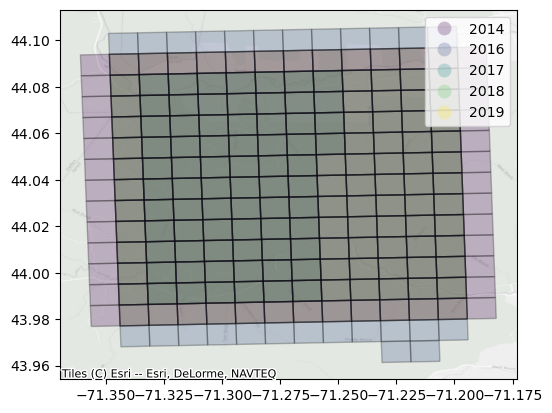

In [26]:
ax = neon_footprints_gdf[neon_footprints_gdf['site'] == SITE].to_crs(4326).plot(alpha=0.25, column='year', cmap='viridis', legend=True, ec='black')
ax = ctx.add_basemap(ax, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas)

In [27]:
m = neon_footprints_gdf[(neon_footprints_gdf['site'] == SITE)].explore(column='year', cmap='viridis', legend=True, 
                                                                       style_kwds=dict(color="white",weight=1, opacity=0.1, fillOpacity=.5))
m